In [1]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install jax
!pip install jaxlib
!pip install git+https://github.com/professorwug/diffusion-curvature
!pip install pygsp
!pip install graphtools
!pip install tqdm
!pip install nbdev

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from diffusion_curvature.core import DiffusionCurvature, DiffusionLaziness

In [3]:
#Hyperparameters and model
batch_size = 128
num_epochs = 20
learning_rate = 0.01
dim_value = 16
output_directory = "./outputs"
os.makedirs(output_directory, exist_ok = True)
device = ("cuda" if torch.cuda.is_available() else "cpu")

class SimpleMLP(nn.Module):
  def __init__(self, num_classes=10):
    super(SimpleMLP, self).__init__()
    self.flatten = nn.Flatten()
    self.layers = nn.Sequential(
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, dim_value),
        nn.ReLU(),
        nn.Linear(dim_value, num_classes)
        )

  def forward(self, x):
    x = self.flatten(x)
    output = self.layers(x)
    return output

In [4]:
#import datasets and initalize dataloader
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))])
train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.89MB/s]


In [5]:
# model initialization

model = SimpleMLP(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# A python hook to store stuff about penultimate embeddings
penultimate_embeddings = []
def hook_fn(module, input, output):
    # output shape: (batch_size, 256)
    embedding = output.detach().cpu().numpy()
    penultimate_embeddings.append(embedding)

hook = model.layers[2].register_forward_hook(hook_fn)

#Diffusion Curvature
from diffusion_curvature.kernels import get_adaptive_graph, get_fixed_graph
from functools import partial

Diff_curv = DiffusionCurvature(
    graph_former = partial(get_adaptive_graph, k = 10)
)

In [6]:
!pip install 'phate'
import phate
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.1/94.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 107.3 MB/s eta 0:00:00
  Created wheel for s-gd2: filename=s_gd2-1.8.1-cp311-cp311-linux_x86_64.whl size=537221 sha256=958d3565a2d200466fda9fb9d364b2415e3ca3983ebd45d1e48293b090bc72c2
  Stored in directory: /root/.cache/pip/wheels/02/a3/d0/f92b1a96695e0792d1546fe2e108dabfcd31fca107ff39ead2
Successfully built s-gd2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.0.3 which is incompatible.
fastai 2.

The loss in epoch 1 is 63.40276714682833. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:25:07,487:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)}


2025-05-05 17:25:17,237:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:25:20,842:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:25:23,146:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:25:29,461:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:25:32,886:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:25:35,786:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:25:39,117:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:25:41,858:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:25:44,061:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 1) → mean -5.2763, std 1.7784


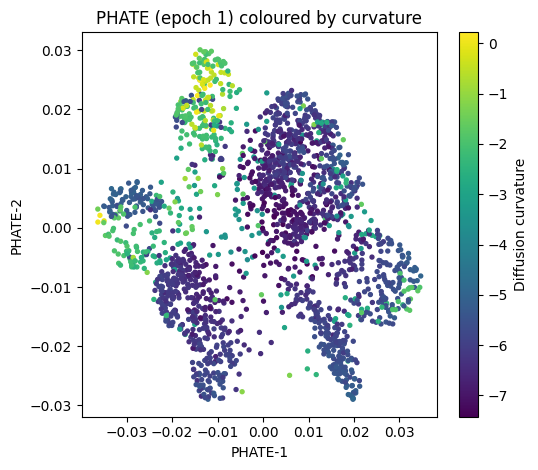

The loss in epoch 2 is 20.594839032779117. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:26:54,091:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)}


2025-05-05 17:26:59,385:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:27:01,833:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:27:03,916:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:27:06,122:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:27:09,350:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:27:11,597:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:27:13,898:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:27:16,157:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:27:18,368:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 2) → mean -4.9484, std 1.5787


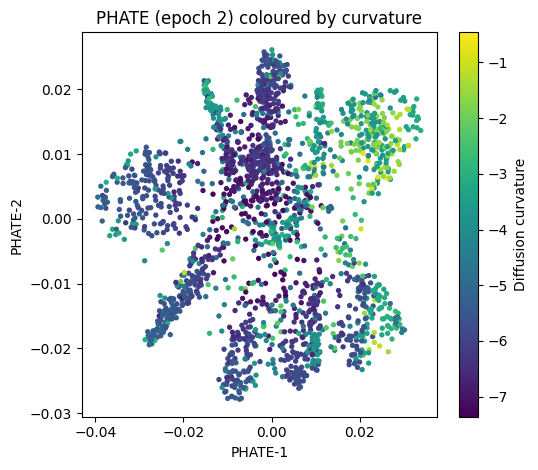

The loss in epoch 3 is 13.817373962290505. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:28:34,642:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)}


2025-05-05 17:28:40,132:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:28:42,442:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:28:44,999:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:28:47,264:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:28:50,457:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:28:52,739:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:28:55,545:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:28:57,765:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:29:00,004:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 3) → mean -5.7205, std 1.2055


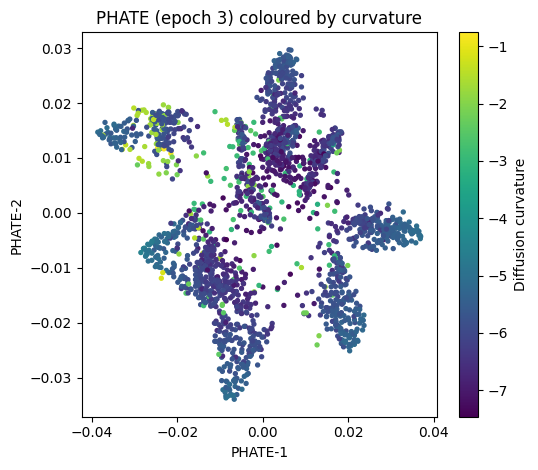

The loss in epoch 4 is 10.42876694248175. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:30:12,950:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)}


2025-05-05 17:30:18,648:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:30:20,912:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:30:23,186:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:30:25,970:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:30:28,291:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:30:31,554:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:30:33,829:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:30:36,010:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:30:38,201:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 4) → mean -5.8946, std 1.0174


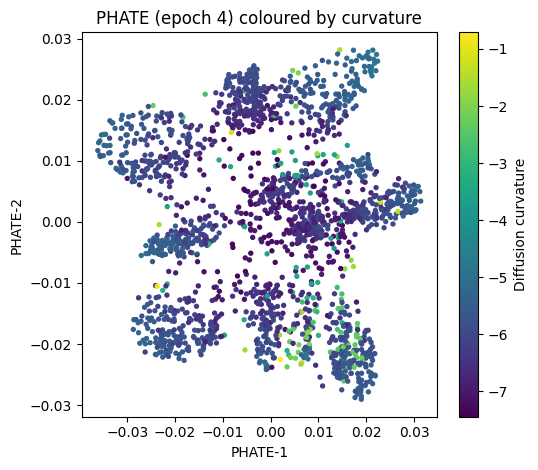

The loss in epoch 5 is 8.164905934953994. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:31:52,817:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)}


2025-05-05 17:31:58,111:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:32:00,755:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:32:03,211:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:32:05,741:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:32:07,967:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:32:10,897:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:32:14,075:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:32:16,133:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:32:18,654:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 5) → mean -5.9170, std 0.9797


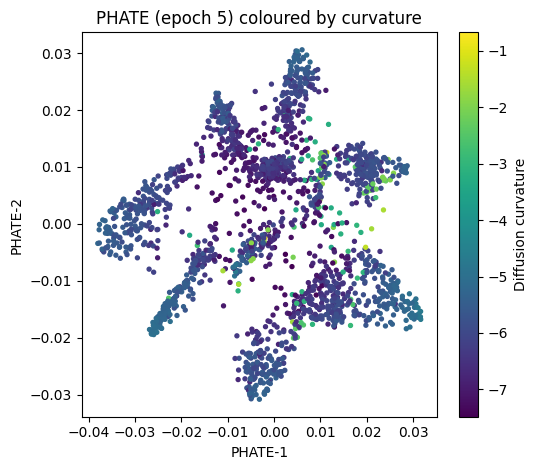

The loss in epoch 6 is 6.598425862631564. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:33:25,284:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)}


2025-05-05 17:33:31,127:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:33:33,575:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:33:36,021:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:33:39,284:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:33:42,627:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:33:45,061:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:33:47,943:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:33:50,858:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:33:54,272:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 6) → mean -5.5952, std 1.1734


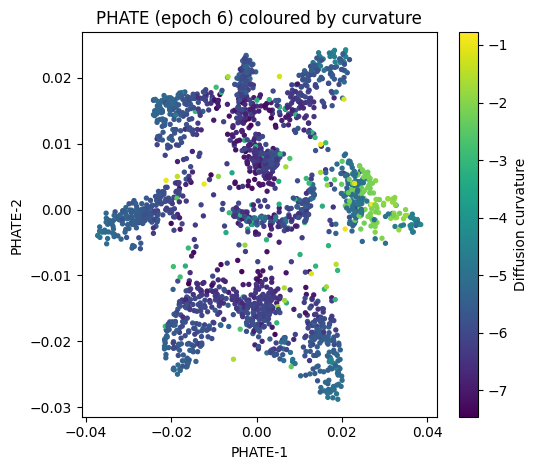

The loss in epoch 7 is 5.379014504362525. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:35:11,080:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)}


2025-05-05 17:35:16,297:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:35:19,765:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:35:23,034:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:35:26,459:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:35:29,466:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:35:31,984:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:35:35,580:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:35:37,711:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:35:39,990:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 7) → mean -5.8994, std 0.8441


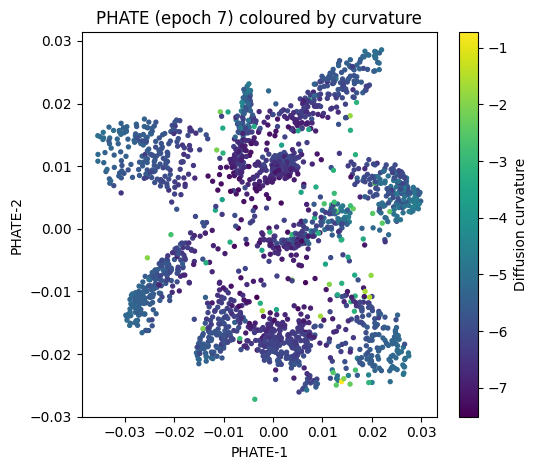

The loss in epoch 8 is 4.676396641395748. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:36:48,386:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)}


2025-05-05 17:36:54,734:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:36:57,197:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:37:00,795:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:37:04,893:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:37:07,488:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:37:09,742:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:37:13,070:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:37:16,171:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:37:18,556:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 8) → mean -5.9856, std 0.8362


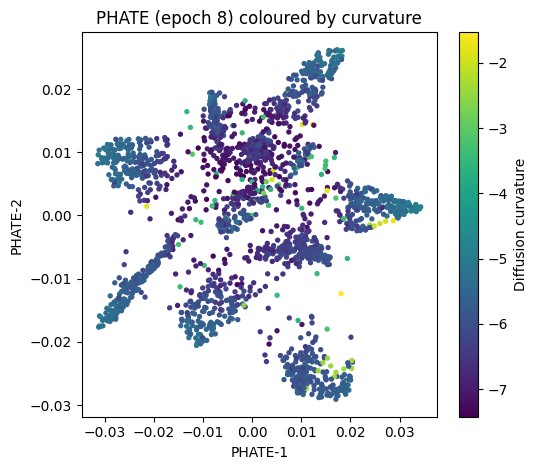

The loss in epoch 9 is 3.826636999082972. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:38:25,832:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)}


2025-05-05 17:38:32,682:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:38:35,794:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:38:39,818:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:38:44,102:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:38:47,834:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:38:50,234:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:38:53,559:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:38:57,618:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:38:59,852:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 9) → mean -6.0450, std 0.7162


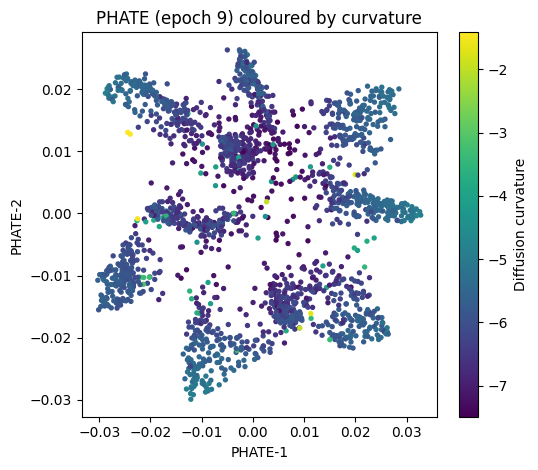

The loss in epoch 10 is 3.190642163443413. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:40:15,245:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)}


2025-05-05 17:40:20,710:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:40:24,950:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:40:27,651:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:40:31,288:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:40:34,500:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:40:37,770:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:40:40,926:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:40:43,046:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:40:45,560:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 10) → mean -6.0526, std 0.7222


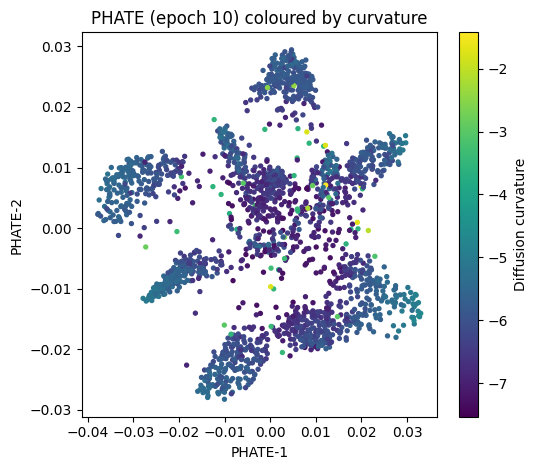

The loss in epoch 11 is 2.7569362437292964. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:41:55,841:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)}


2025-05-05 17:42:02,855:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:42:07,203:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:42:09,992:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:42:12,765:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:42:17,128:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:42:19,857:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:42:23,020:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:42:25,266:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:42:28,987:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 11) → mean -5.8101, std 1.0084


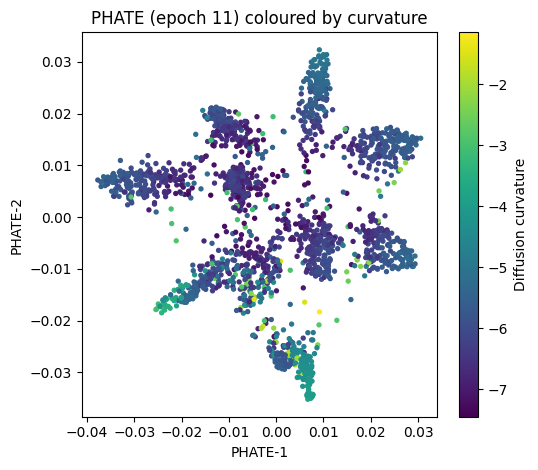

The loss in epoch 12 is 2.3005152792056234. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:43:51,581:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)}


2025-05-05 17:43:58,895:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:44:01,471:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:44:06,999:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:44:10,326:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:44:13,795:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:44:17,352:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:44:20,887:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:44:24,486:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:44:27,199:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 12) → mean -6.0638, std 0.7666


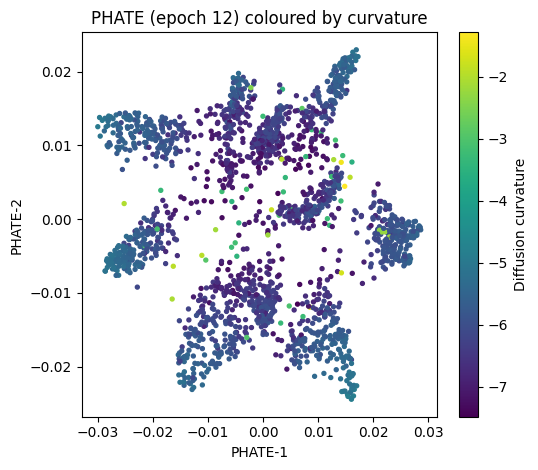

The loss in epoch 13 is 1.9515814648381173. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:45:46,729:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)}


2025-05-05 17:45:52,867:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:45:58,273:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:46:02,756:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:46:06,050:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:46:11,002:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:46:13,562:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:46:17,780:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:46:21,347:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:46:23,790:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 13) → mean -5.9588, std 0.7994


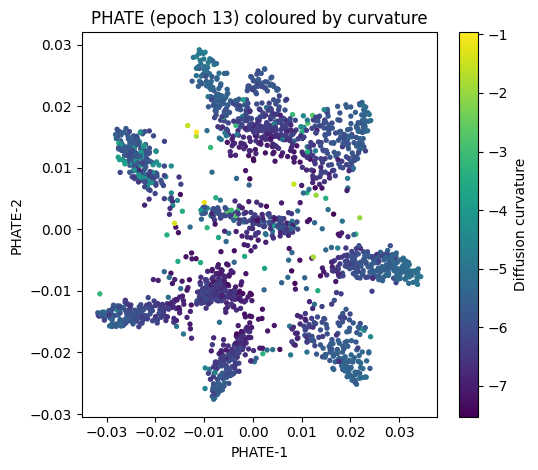

The loss in epoch 14 is 1.7563709172168012. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:47:41,416:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)}


2025-05-05 17:47:47,271:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:47:49,571:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:47:52,158:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:47:55,089:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:47:59,633:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:48:02,505:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:48:04,848:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:48:06,884:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:48:09,490:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 14) → mean -6.0411, std 0.8055


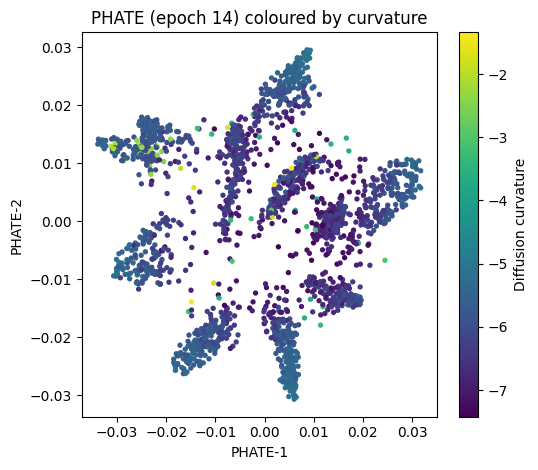

The loss in epoch 15 is 1.553905333886777. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:49:25,455:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)}


2025-05-05 17:49:31,648:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:49:34,942:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:49:37,581:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:49:40,566:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:49:42,877:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:49:45,184:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:49:47,448:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:49:49,735:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:49:52,821:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 15) → mean -6.0294, std 0.7028


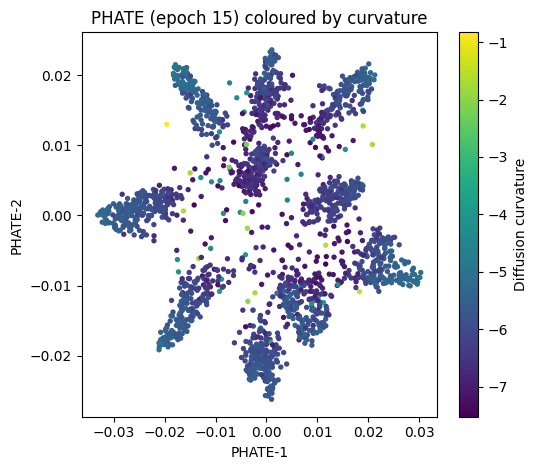

The loss in epoch 16 is 1.402818248851467. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:51:05,890:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)}


2025-05-05 17:51:11,885:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:51:14,091:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:51:16,366:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:51:19,829:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:51:22,424:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:51:24,736:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:51:27,019:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:51:29,171:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:51:31,687:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 16) → mean -5.8615, std 0.8880


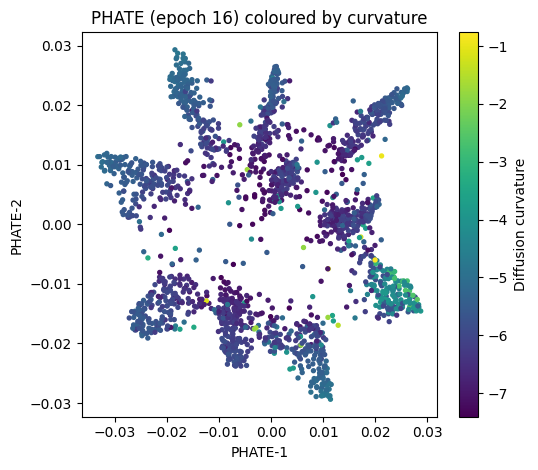

The loss in epoch 17 is 1.2792964678392735. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:52:53,114:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)}


2025-05-05 17:52:58,175:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:53:01,018:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:53:04,568:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:53:07,102:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:53:09,398:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:53:11,885:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:53:15,229:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:53:17,471:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:53:20,015:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 17) → mean -6.0323, std 0.6928


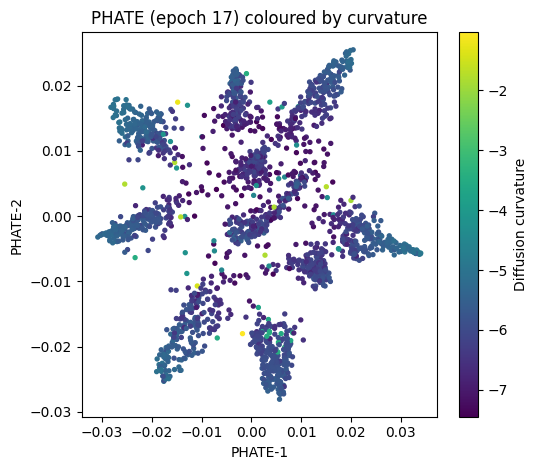

The loss in epoch 18 is 1.1880153294946594. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:54:40,363:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)}


2025-05-05 17:54:46,888:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:54:49,570:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:54:51,834:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:54:54,927:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:54:57,769:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:55:00,077:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:55:02,306:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:55:04,474:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:55:06,669:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 18) → mean -5.8542, std 0.8253


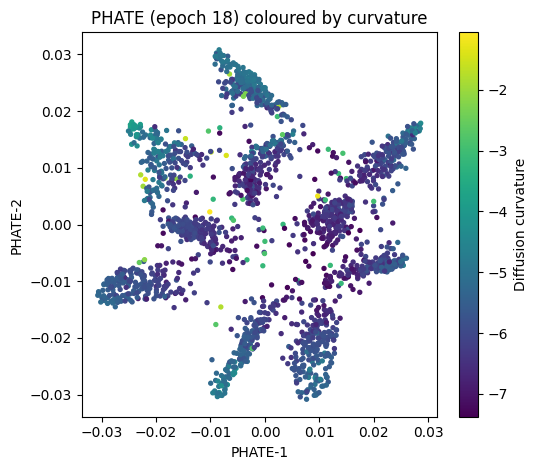

The loss in epoch 19 is 1.0729272260721812. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:56:29,466:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)}


2025-05-05 17:56:34,573:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:56:37,067:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:56:39,992:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:56:42,266:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:56:45,093:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:56:47,418:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:56:50,851:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:56:53,384:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:56:55,633:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 19) → mean -6.0389, std 0.8140


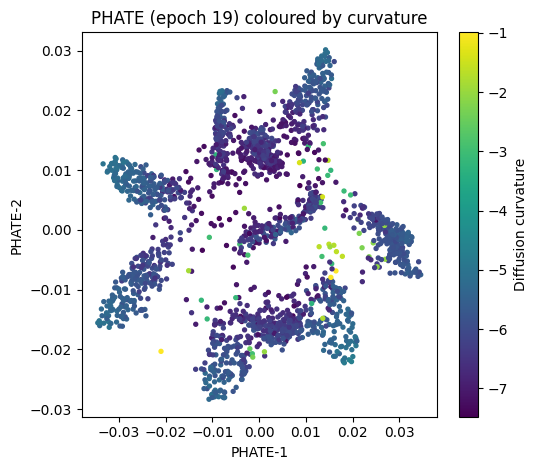

The loss in epoch 20 is 1.0218193957419284. 
Saved penultimate embeddings shape: (60000, 16)


2025-05-05 17:58:17,743:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Estimated dimension(s) in point cloud: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)}


2025-05-05 17:58:24,755:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:58:27,060:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:58:29,442:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:58:32,973:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:58:35,602:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:58:37,952:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:58:40,279:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:58:42,546:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!
2025-05-05 17:58:45,358:[WARNING](pygsp.graphs.graph.che

Curvature (epoch 20) → mean -6.1160, std 0.6985


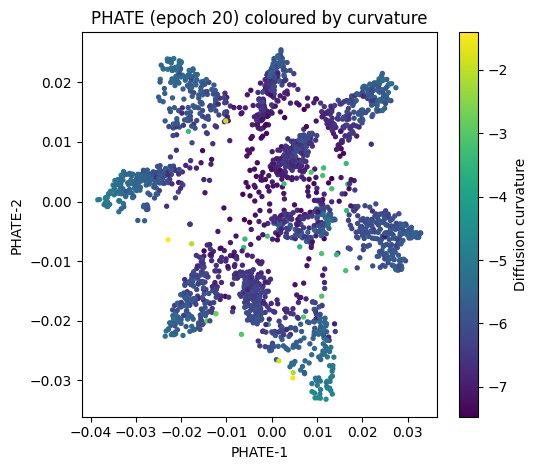

In [7]:
# Training the model and getting embeddings

def train():
  for epoch in range(1,num_epochs+1):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss/len(train_loader)
    print(f"The loss in epoch {epoch} is {epoch_loss}. ")

    penultimate_embeddings.clear()
    model.eval()
    with torch.no_grad():
            for images, _ in train_loader:
                images = images.to(device)
                _ = model(images)
    ebdgs = np.concatenate(penultimate_embeddings, axis=0)
    idx = np.random.choice(ebdgs.shape[0], 2000, replace=False)
    np.save(os.path.join(output_directory, f"feats_epoch_{epoch}_curv_dim{dim_value}.npy"), ebdgs)
    print(f"Saved penultimate embeddings shape: {ebdgs.shape}")
    curv = Diff_curv.fit_transform(
        X=ebdgs[idx],
        locality_scale=0.1,
        graph_knn=30
    )
    print(f"Curvature (epoch {epoch}) → mean {curv.mean():.4f}, std {curv.std():.4f}")
    np.save(os.path.join(output_directory, f"curv_epoch_{epoch}_curv_dim{dim_value}.npy"), curv)

    phate_op = phate.PHATE(n_components=2, knn=30, n_jobs=-1, verbose=False)
    phate_2d = phate_op.fit_transform(ebdgs[idx])

    np.save(os.path.join(output_directory,
                         f"phate2d_epoch_{epoch}.npy"),
            phate_2d)

    # scatter plot coloured by curvature
    plt.figure(figsize=(5.5, 4.8))
    sc = plt.scatter(phate_2d[:, 0], phate_2d[:, 1], c=curv, s=8, cmap='viridis')
    plt.title(f'PHATE (epoch {epoch}) coloured by curvature')
    plt.xlabel('PHATE‑1');   plt.ylabel('PHATE‑2')
    plt.colorbar(sc, label='Diffusion curvature')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, f"phate2d_epoch_{epoch}.png"), dpi=300)
    plt.show()
    plt.close()



train()

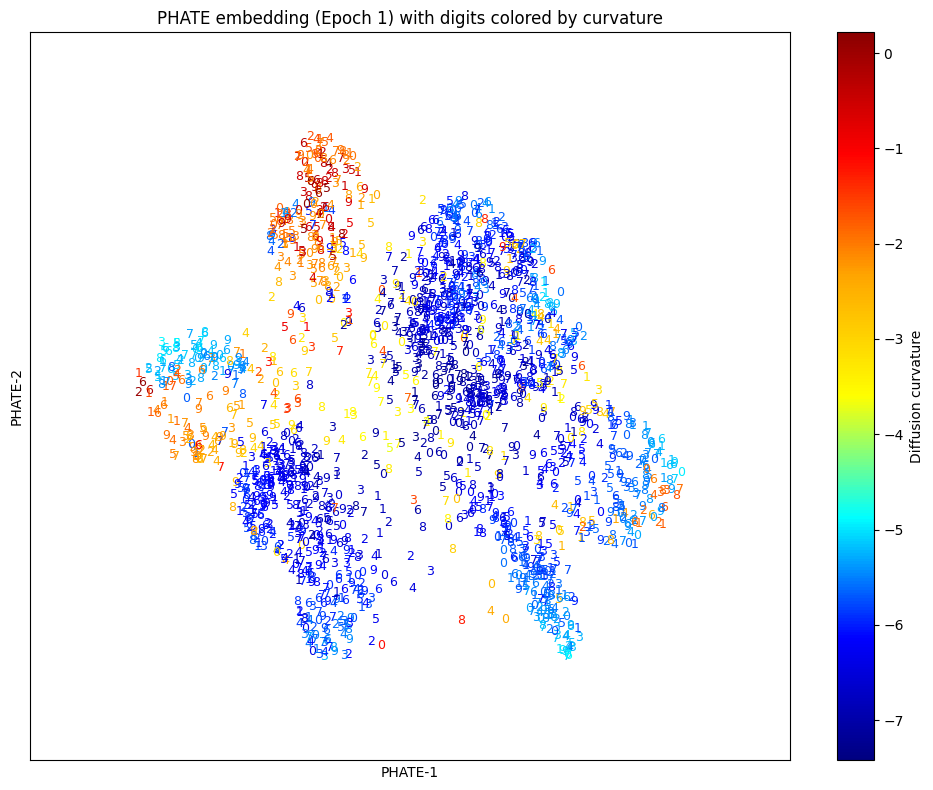

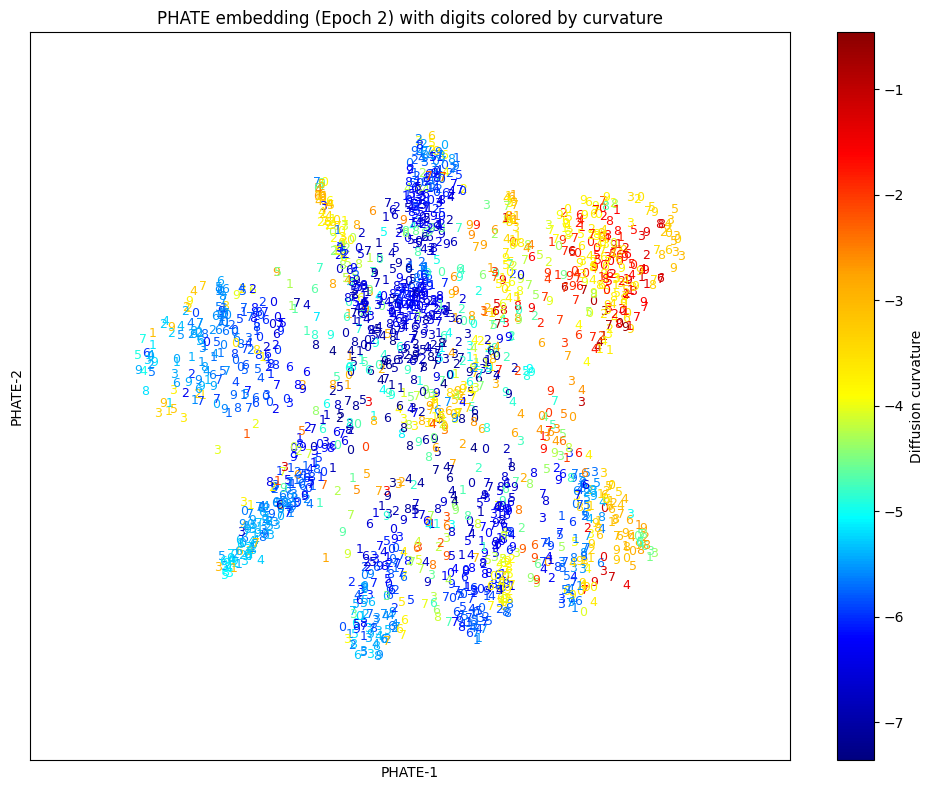

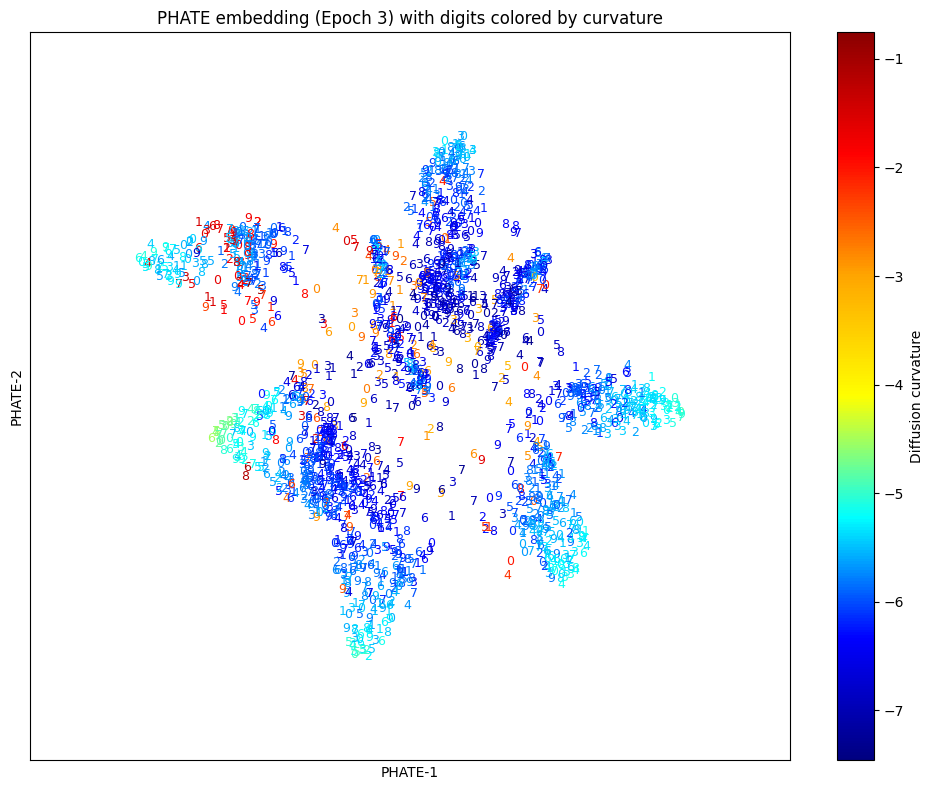

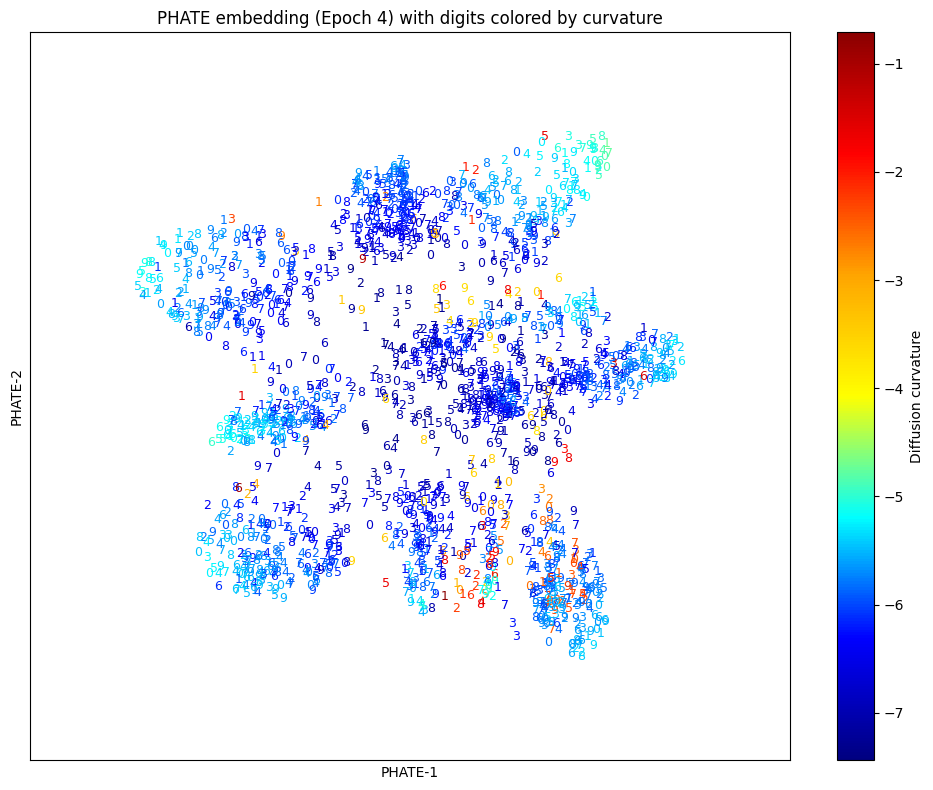

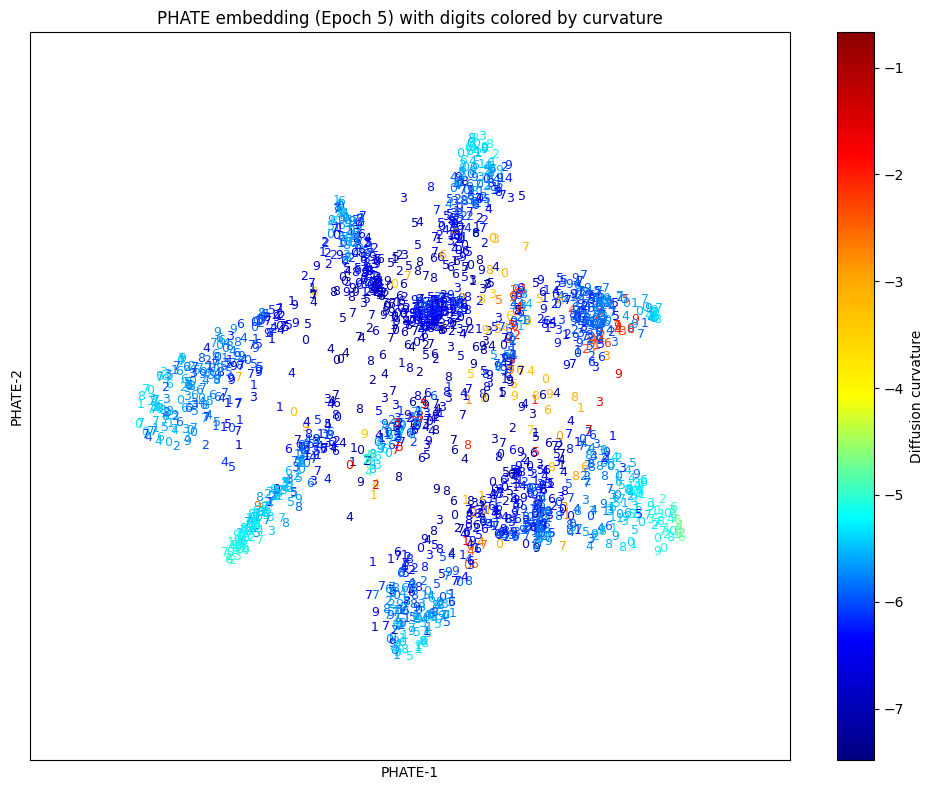

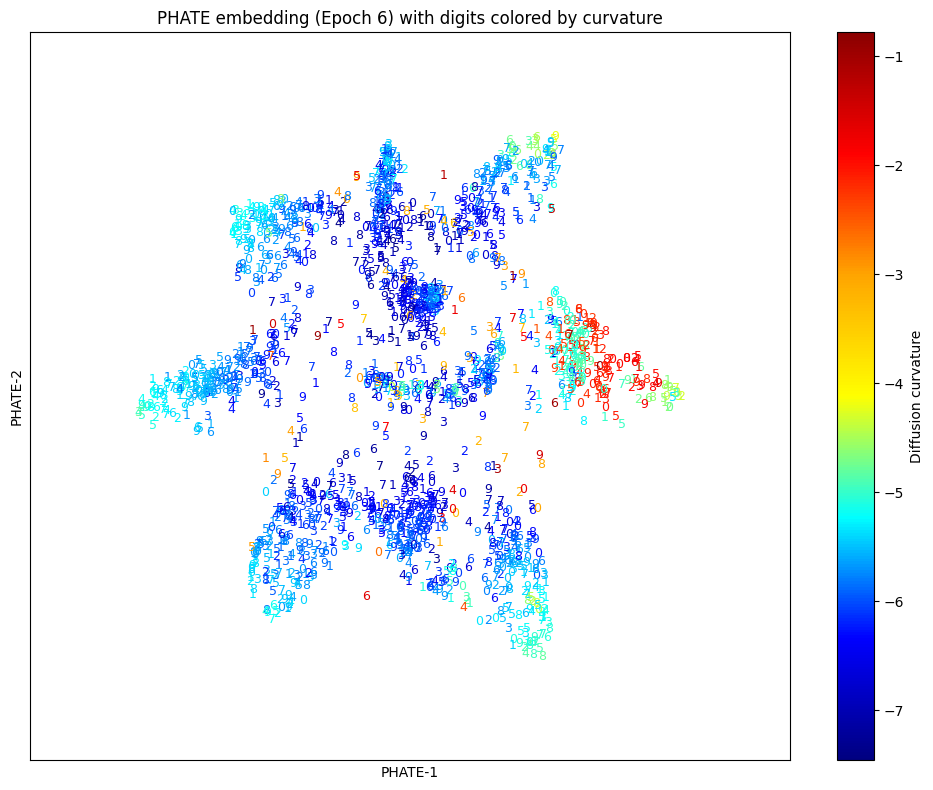

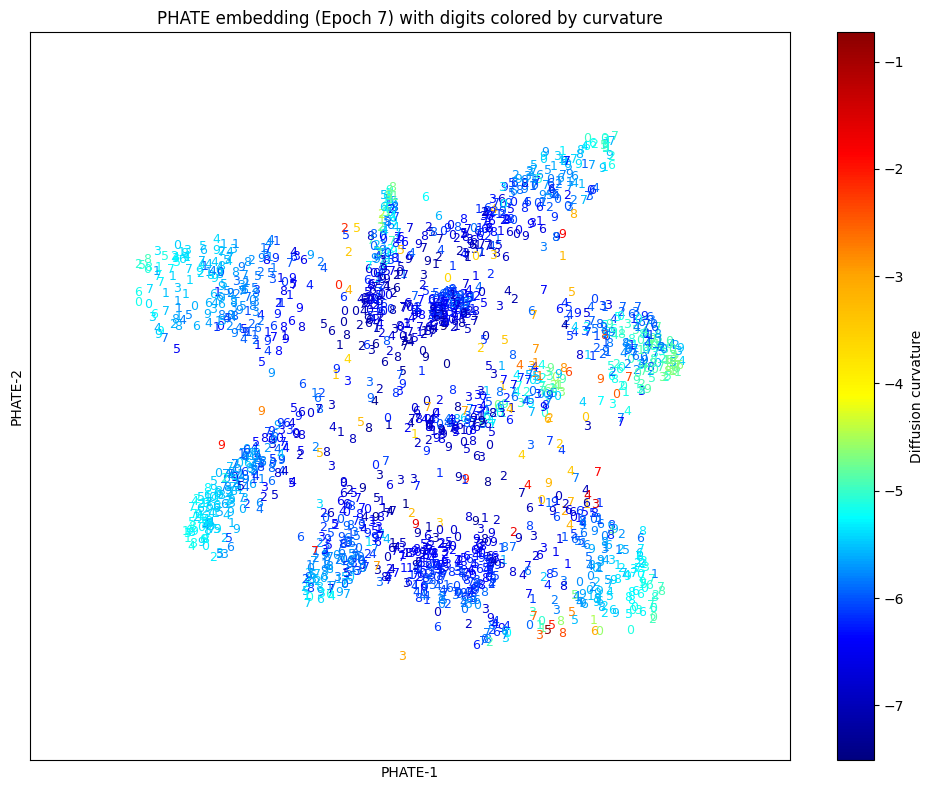

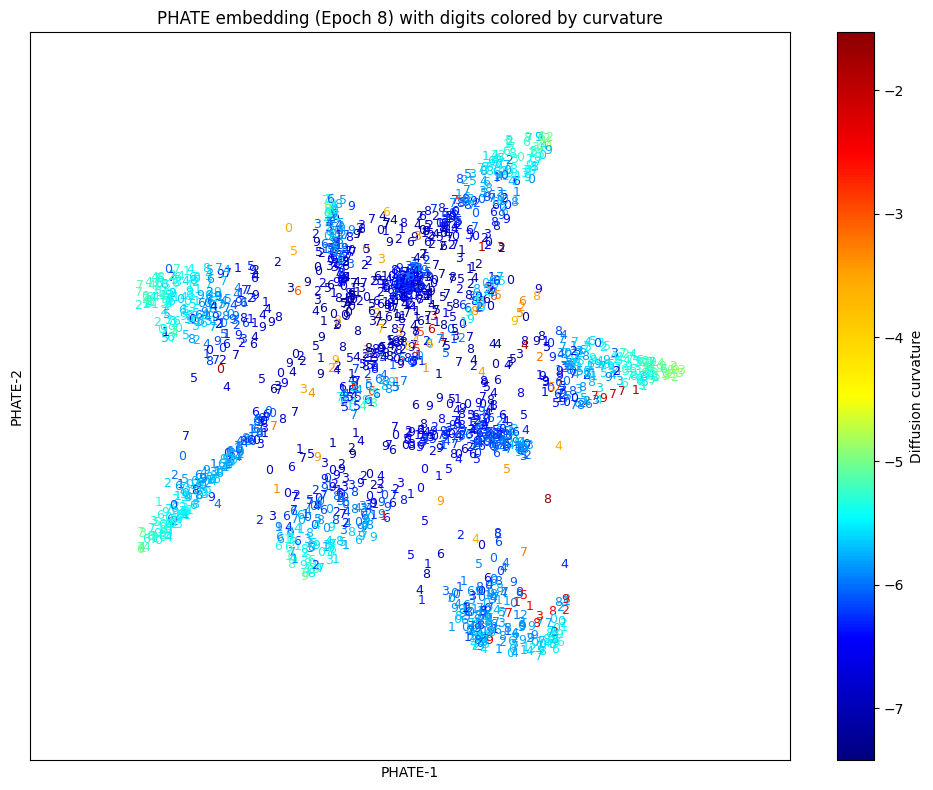

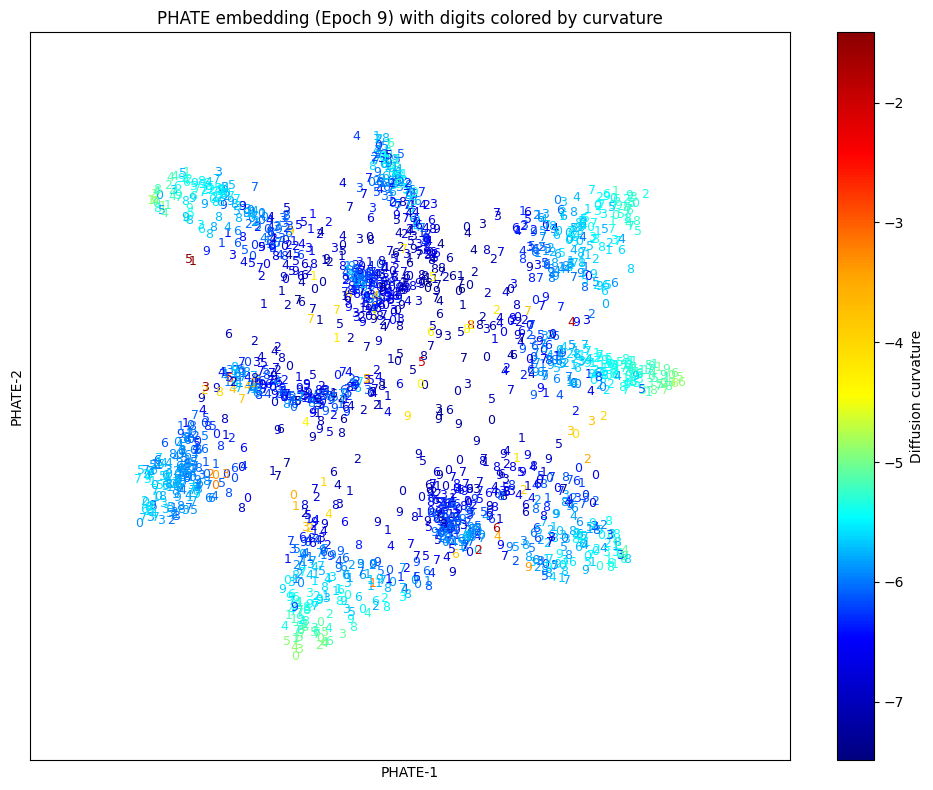

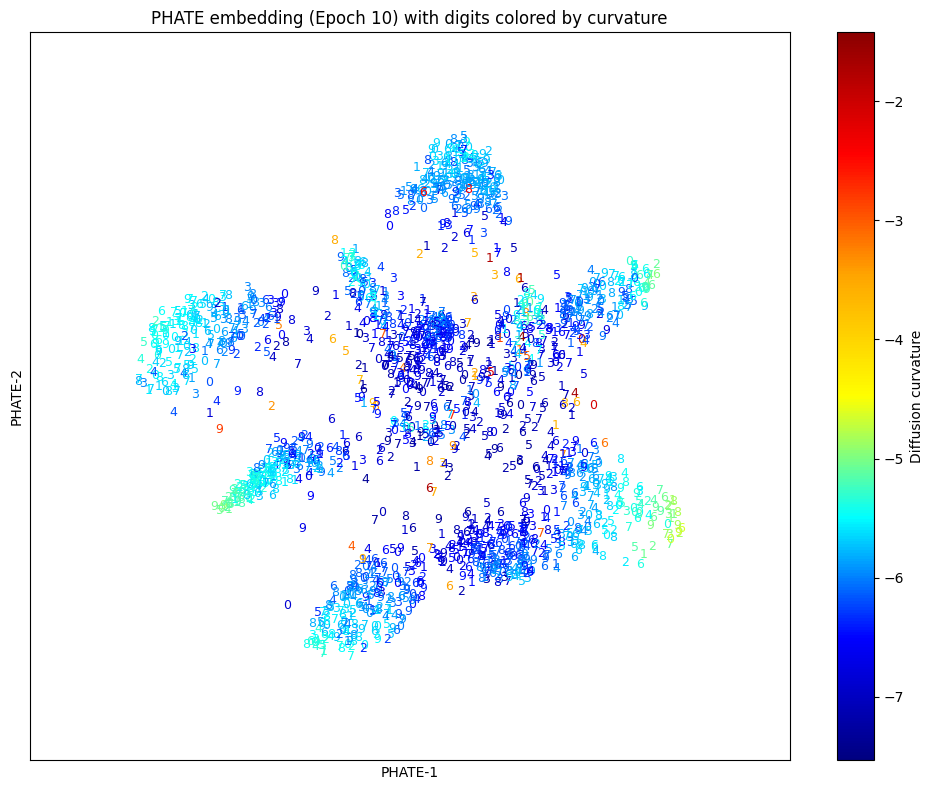

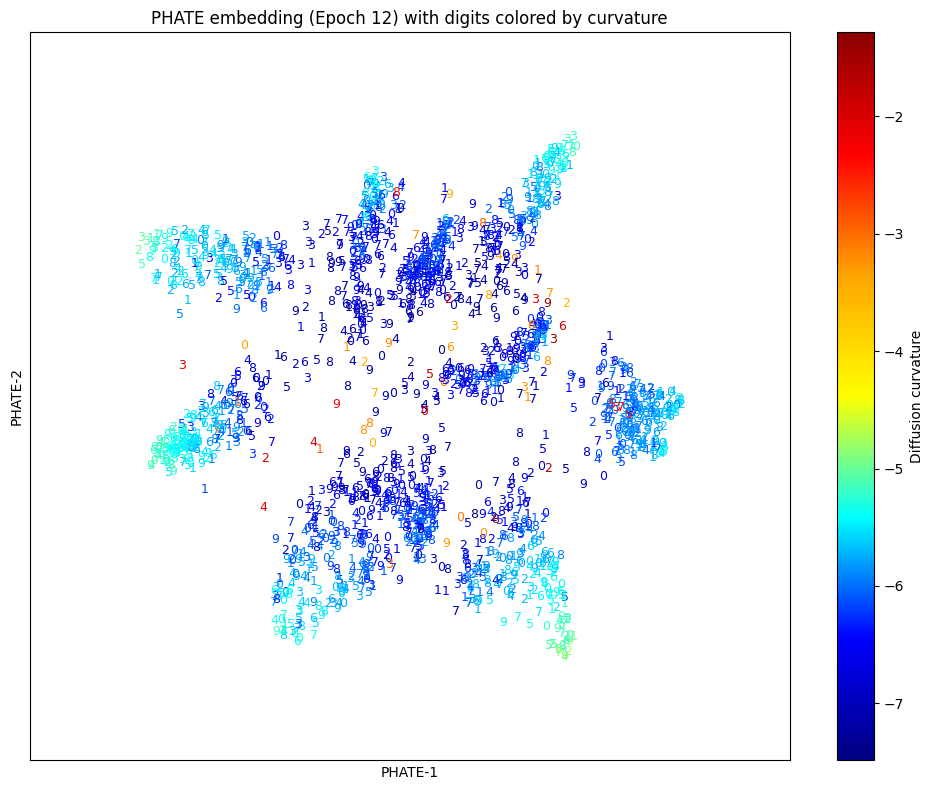

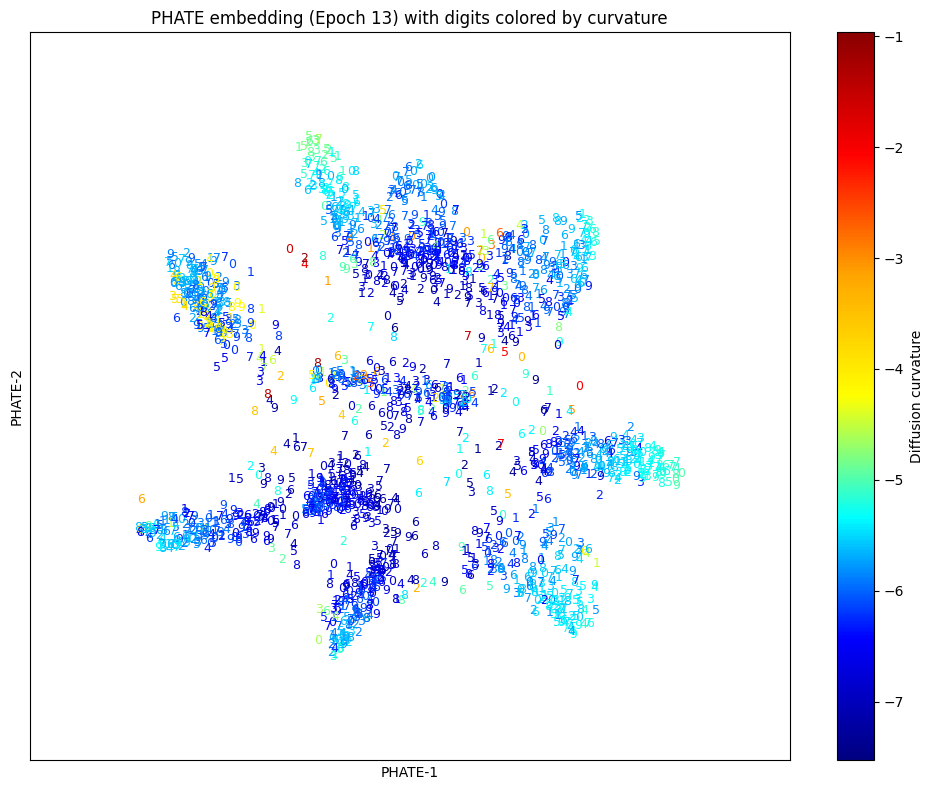

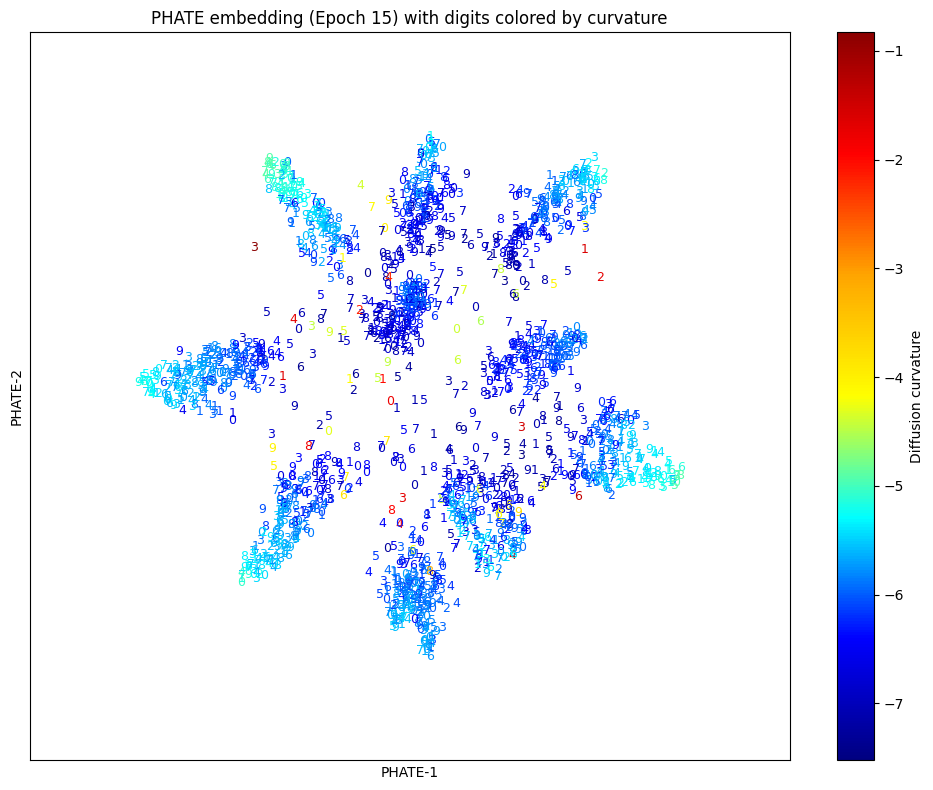

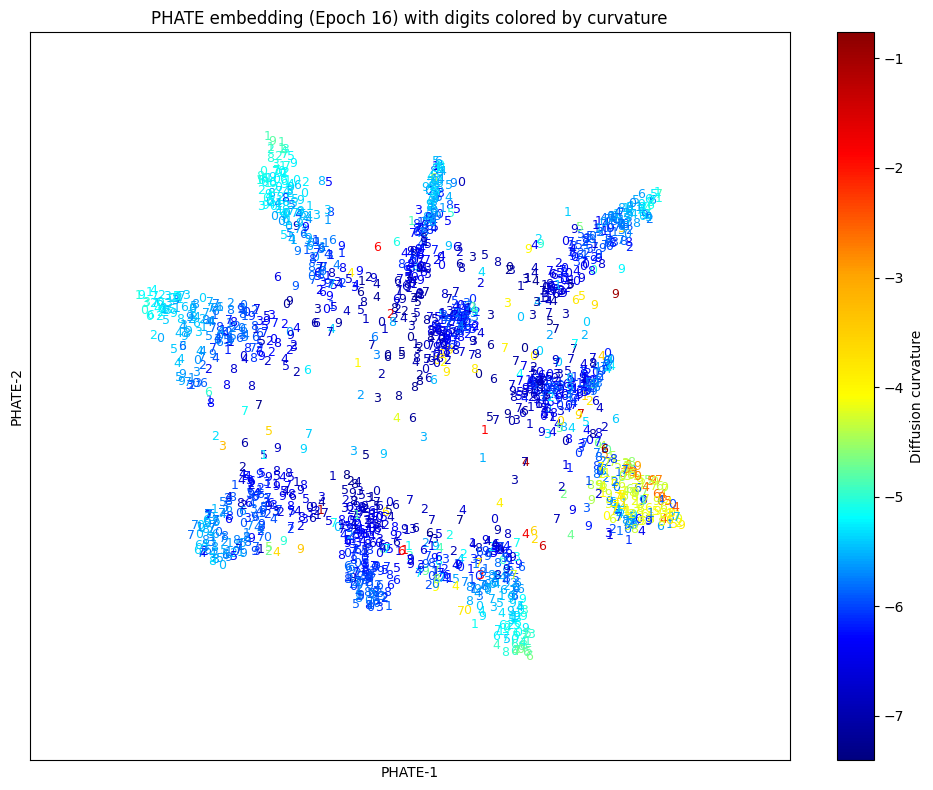

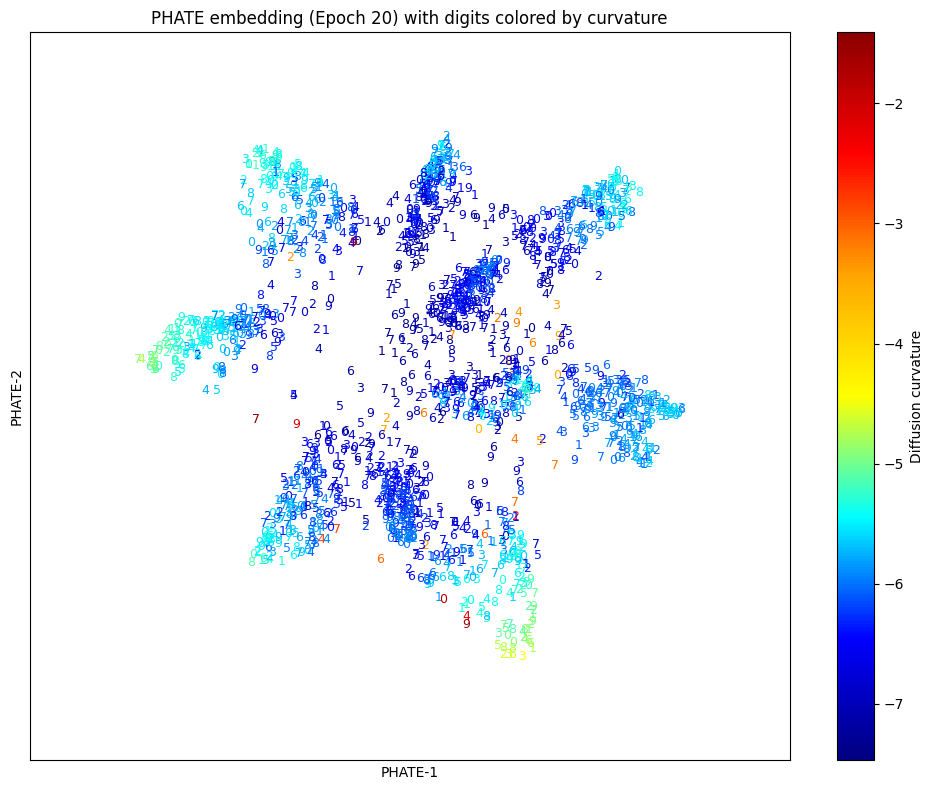

In [8]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize

plots_folder = "./curvature_plots"
os.makedirs(plots_folder, exist_ok=True)

# load labels
all_labels = []
for _, label_batch in train_loader:
    all_labels.extend(label_batch.cpu().numpy())
all_labels = np.array(all_labels)

np.random.seed(42)
idx = np.random.choice(len(all_labels), 2000, replace=False)
digit_labels = all_labels[idx]

# create plots
for epoch in range(1, num_epochs + 1):
    phate_2d = np.load(os.path.join(output_directory, f"phate2d_epoch_{epoch}.npy"))
    curv = np.load(os.path.join(output_directory, f"curv_epoch_{epoch}_curv_dim{dim_value}.npy"))

    fig, ax = plt.subplots(figsize=(10, 8))

    # custom color map for more differentiation
    colors = ["navy", "blue", "cyan", "yellow", "orange", "red", "darkred"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", colors)

    norm = Normalize(vmin=np.min(curv), vmax=np.max(curv))

    for i in range(len(phate_2d)):
        ax.text(phate_2d[i, 0], phate_2d[i, 1], str(digit_labels[i]),
                color=custom_cmap(norm(curv[i])),
                fontsize=9, ha='center', va='center')


    # set axes limits
    x_min, x_max = np.min(phate_2d[:, 0]), np.max(phate_2d[:, 0])
    y_min, y_max = np.min(phate_2d[:, 1]), np.max(phate_2d[:, 1])

    x_padding = (x_max - x_min) * 0.2
    y_padding = (y_max - y_min) * 0.2

    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)

    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Diffusion curvature')

    ax.set_title(f'PHATE embedding (Epoch {epoch}) with digits colored by curvature')
    ax.set_xlabel('PHATE-1')
    ax.set_ylabel('PHATE-2')

    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(os.path.join(plots_folder, f"phate2d_digits_colored_epoch_{epoch}.png"), dpi=300)
    plt.show()

In [9]:
!zip -r /content/all_files.zip /content

from google.colab import files
files.download('/content/all_files.zip')

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.05.02/ (stored 0%)
  adding: content/.config/logs/2025.05.02/13.32.47.744427.log (deflated 93%)
  adding: content/.config/logs/2025.05.02/13.33.18.977287.log (deflated 58%)
  adding: content/.config/logs/2025.05.02/13.33.17.734755.log (deflated 87%)
  adding: content/.config/logs/2025.05.02/13.33.28.819597.log (deflated 57%)
  adding: content/.config/logs/2025.05.02/13.33.28.09

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>